In [3]:
from google.colab import files
 
 
uploaded = files.upload()

Saving data_transformations.py to data_transformations.py
Saving ffgsm_.py to ffgsm_.py
Saving fgsm_.py to fgsm_.py
Saving models.py to models.py
Saving no_attack.py to no_attack.py
Saving pgd_.py to pgd_.py
Saving pgdl2_.py to pgdl2_.py
Saving rep_transformations.py to rep_transformations.py
Saving slide_.py to slide_.py
Saving stochastic_attack.py to stochastic_attack.py


In [6]:
#Import libraries

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

#from torchattacks import PGD, FGSM, FFGSM
import rep_transformations as rt
from no_attack import NO_ATTACK
from stochastic_attack import STOCHASTIC_ATTACK
from fgsm_ import FGSM_
from ffgsm_ import FFGSM_
from slide_ import SLIDE_
from pgd_ import PGD_
from pgdl2_ import PGDL2_
from data_transformations import DctBlurry

In [5]:
pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 155 kB 15.1 MB/s 


In [7]:
#Show CUDA settings

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {cuda_id}")

cuda_name = torch.cuda.get_device_name(cuda_id)
print(f"Name of current CUDA device: {cuda_name}\n")
print(f"CUDA devide properties: {torch.cuda.get_device_properties(0)}")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device: 0
Name of current CUDA device: Tesla T4

CUDA devide properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [8]:
#Downloading Fashion MNIST Dataset
train_list_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        DctBlurry(threshold=5),
    ])

test_list_transforms = transforms.Compose([
        transforms.ToTensor(),
    ])

fashion_mnist_train = dsets.FashionMNIST(root='./data1/',
                          train=True,
                          transform=train_list_transforms,
                          download=True)

fashion_mnist_aux = dsets.FashionMNIST(root='./data1/',
                         train=False,
                         transform=test_list_transforms,
                         download=True)

fashion_mnist_test, fashion_mnist_valid = torch.utils.data.random_split(fashion_mnist_aux, [5000, 5000], generator=torch.Generator().manual_seed(42))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data1/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data1/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data1/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data1/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data1/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data1/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data1/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data1/FashionMNIST/raw



In [9]:
#Initialize DataLoader

batch_size = 128
torch.manual_seed(0)
n_workers = 5

train_loader  = torch.utils.data.DataLoader(dataset=fashion_mnist_train,
                                           batch_size=batch_size,
                                           shuffle=42, num_workers=n_workers)

test_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_test,
                                         batch_size=batch_size,
                                         shuffle=42, num_workers=n_workers)

valid_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_valid,
                                         batch_size=batch_size,
                                         shuffle=42, num_workers=n_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
#Initialize transformations

id_transf = rt.Identity()
fft_transf = rt.FFT()
dct_transf = rt.DCT()
jpeg_transf = rt.JPEG()

list_transf = [id_transf, fft_transf, dct_transf, jpeg_transf]

In [11]:
#Get model and optimizer

def generate_model(pretrained=True, lr=0.001):

    #Init model and optimizer
    model = torchvision.models.resnet50(pretrained=True).cuda() #CNN.cuda() to resnet 50
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    #Change model architecture 
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(2048, 10, bias=True)
    
    #Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        model.to(device)
        
    return model, optimizer

In [12]:
#modified test function with 3 attacks and toggle between Pixel and DCT representation.Default is Pixel

def get_accuracy(model, test_loader, atk):
    
    model.eval()
    correct = 0
    total = 0    

    for images, labels in test_loader:

        images = atk(images, labels).cuda()              
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    return 100 * float(correct) / total

In [13]:
#train function with PGD attack and toggle between DCT and Pixel representation .Default is Pixel

def train_(model, train_loader, optimizer, loss, atk, num_epochs=5):

    model.train()

    for epoch in range(num_epochs):

        total_batch = len(fashion_mnist_train) // batch_size
        
        for i, (batch_images, batch_labels) in enumerate(train_loader):

           
            Y = batch_labels.cuda()
            X = atk(batch_images, batch_labels).cuda()

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Train. Atk: {atk.attack}, Epoch [{epoch+1}/{num_epochs}], lter [{i+1}/{total_batch}], Loss: {cost.item()}')
    return cost

In [14]:
def round_robin(model, train_loader, optimizer, loss, atks_list, num_epochs=5):

    model.train() 
    num_attacks = len(atks_list)
    total_batch = len(fashion_mnist_train) // batch_size

    for epoch in range(num_epochs): #+1 to round up

        count = 0

        for i, (batch_images, batch_labels) in enumerate(train_loader):

            atk = atks_list[count]
            Y = batch_labels.cuda()
            X = atk(batch_images, batch_labels).cuda()

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            count += 1
            count %= num_attacks

            if (i+1) % 100 == 0:
                print(f'RR. Epoch [{epoch+1}/{num_epochs}], lter [{i+1}/{total_batch}], Loss: {cost.item()}')
    return cost

In [15]:
def greedy(model, train_loader, valid_loader, optimizer, loss, atks_list, num_epochs=5):

    num_attacks = len(atks_list)
    total_batch = len(fashion_mnist_train) // batch_size

    for epoch in range(num_epochs):

        loss_list = [0]*num_attacks

        model.eval()

        for i, (batch_images, batch_labels) in enumerate(valid_loader):

            Y = batch_labels.cuda()
            current_batch_size = Y.shape[0]

            for i, atk in enumerate(atks_list):

                X = atk(batch_images, batch_labels).cuda()

                pre = model(X)
                cost = loss(pre, Y)

                loss_list[i] += float(cost)/current_batch_size

        max_loss_arg = np.argmax(np.array(loss_list))
        atk = atks_list[max_loss_arg]

        print(f"Greedy. Epoch [{epoch+1}/{num_epochs}], Worst loss attack: {atk.attack}, loss: {loss_list[max_loss_arg]}")

        model.train()

        for i, (batch_images, batch_labels) in enumerate(train_loader):

            Y = batch_labels.cuda()
            X = atk(batch_images, batch_labels).cuda()

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Greedy. Epoch [{epoch+1}/{num_epochs}], lter [{i+1}/{total_batch}], Loss: {cost.item()}')
    return cost

In [16]:
def multivariate_probability(model, train_loader, valid_loader, optimizer, loss, atks_list, num_epochs=5):

    num_attacks = len(atks_list)
    total_batch = len(fashion_mnist_train) // batch_size
    w_list = [1]*num_attacks
    eta = 0.1

    for epoch in range(num_epochs):

        loss_list = [0]*num_attacks
        model.eval()

        for i, (batch_images, batch_labels) in enumerate(valid_loader):

            Y = batch_labels.cuda()
            current_batch_size = Y.shape[0]

            for i, atk in enumerate(atks_list):

                X = atk(batch_images, batch_labels).cuda()

                pre = model(X)
                cost = loss(pre, Y)

                loss_list[i] += float(cost)/current_batch_size

        loss_list = np.array(loss_list)
        total_loss = loss_list.sum()
        prob_list = np.cumsum(loss_list)
        prob_list /= total_loss

        log = f"MP. Epoch [{epoch+1}/{num_epochs}], atks: "
        for i, atk in enumerate(atks_list):
            log += f"({atk.attack},{prob_list[i]}) "

        print(log)

        model.train()

        for i, (batch_images, batch_labels) in enumerate(train_loader):

            rand = random.random()
            atk_idx = 0
            for j in range(1,num_attacks):
                if rand > prob_list[j]:
                    atk_idx = j
                else:
                    break

            atk = atks_list[atk_idx]
            Y = batch_labels.cuda()
            X = atk(batch_images, batch_labels).cuda()

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'MP. Epoch [{epoch+1}/{num_epochs}], lter [{i+1}/{total_batch}], Loss: {cost.item()}')
    return cost

In [17]:
def get_model_acc(model, test_loader, atks_list):
    
    model_acc = {}
    
    for atk in atks_list:
        model_atk_acc = get_accuracy(model, test_loader, atk)
        model_acc[atk.attack] = model_atk_acc
        
    return model_acc

In [18]:
#Define attacks_list generation

def generate_atks(model_atk, eps=0.3):
    
    atks_list = []
    atks_list.append(NO_ATTACK(model_atk))
    atks_list.append(STOCHASTIC_ATTACK(model_atk, eps=eps))
    atks_list.append(STOCHASTIC_ATTACK(model_atk, eps=eps, transf=dct_transf))
    atks_list.append(STOCHASTIC_ATTACK(model_atk, eps=eps, transf=jpeg_transf))
    atks_list.append(STOCHASTIC_ATTACK(model_atk, eps=eps, transf=fft_transf))
    atks_list.append(FGSM_(model_atk, eps=eps))
    atks_list.append(FGSM_(model_atk, eps=eps, transf=dct_transf))
    atks_list.append(FGSM_(model_atk, eps=eps, transf=jpeg_transf))
    atks_list.append(FGSM_(model_atk, eps=eps, transf=fft_transf))
        
    return atks_list

In [19]:
def get_model_avg(n_models=1, procedure="None", num_epochs=5):

    loss = nn.CrossEntropyLoss()
    iters_result = {}
    
    for i in range(n_models):
        model, optim = generate_model()
        atks_model = generate_atks(model)
        
        if iters_result == {}:
            for atk in atks_model:
                iters_result[atk.attack] = []

        cost0=train_(model,train_loader,optim,loss,atks_model[0], num_epochs=num_epochs)

        if procedure == "RR":
            cost1 = round_robin(model,train_loader,optim,loss,atks_model, num_epochs=num_epochs)
        elif procedure == "Greedy":
            cost1 = greedy(model,train_loader,valid_loader,optim,loss,atks_model, num_epochs=num_epochs)
        elif procedure == "MP":
            cost1 = multivariate_probability(model,train_loader,valid_loader,optim,loss,atks_model, num_epochs=num_epochs)
        
        acc = get_model_acc(model, test_loader, atks_model)
        
        for (key, value) in acc.items():
            temp = iters_result[key]
            temp.append(value)
            iters_result[key] = temp
            
        print(f'Model average. Iter: {i+1}/{n_models}.')
            
    results = {}
    for (key, values) in iters_result.items():
        aux_array = np.array(values)
        mean = np.mean(aux_array)
        std = np.std(aux_array)
        results[key] = str(round(mean, 2))+"+"+str(round(std, 2))
    
    return results

# Transformation analysis

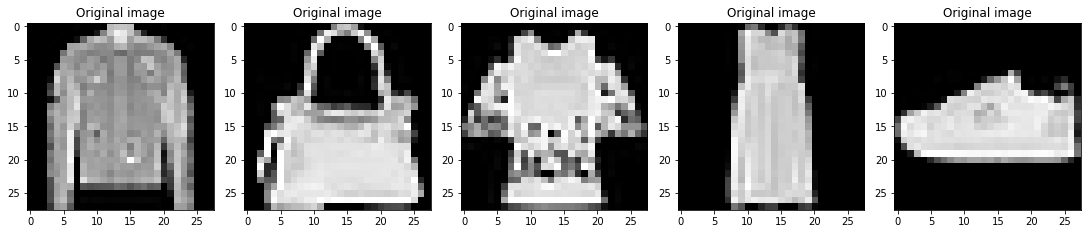

In [20]:
#Show images

num_images = 5
steps = 5
img_size = 3

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
images = example_data[0:num_images]

fig, axs = plt.subplots(1, num_images, constrained_layout=True, figsize=(15, 20))

for i in range(num_images):
    axs[i].imshow(images[i,0], cmap='gray', interpolation='none')
    axs[i].set_title(f'Original image')

## Image representation comparison

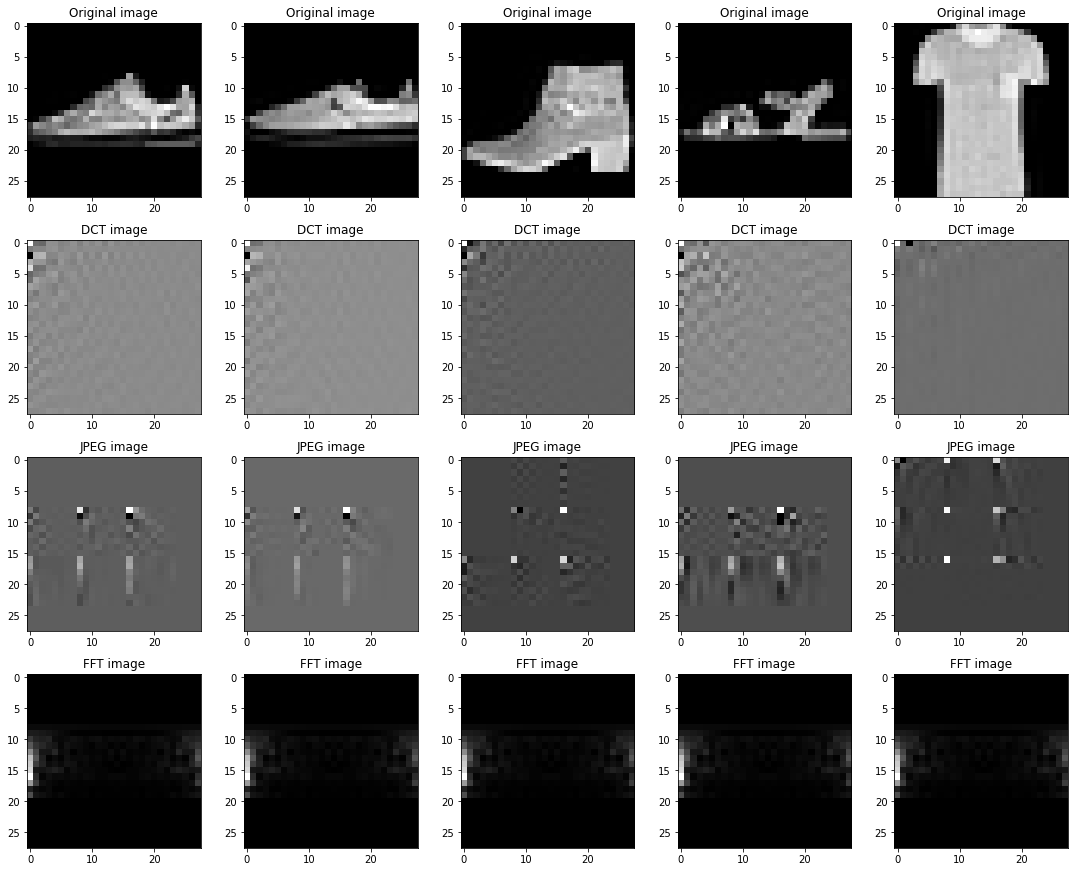

In [21]:
#Pixel vs DCT vs FFT

num_images = 5
steps = 5
img_size = 3

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
images = example_data[0:num_images]

images_dct = rt.block_dct(images)
images_jpeg = rt.batch_dct(images)
images_fft = torch.fft.fft(images)

fig, axs = plt.subplots(4, num_images, constrained_layout=True, figsize=(15, 12))

for i in range(num_images):
    axs[0,i].imshow(images[i,0], cmap='gray', interpolation='none')
    axs[0,i].set_title(f'Original image')

for i in range(num_images):
    axs[1,i].imshow(images_dct[i,0], cmap='gray', interpolation='none')
    axs[1,i].set_title(f'DCT image')

for i in range(num_images):
    axs[2,i].imshow(images_jpeg[i,0], cmap='gray', interpolation='none')
    axs[2,i].set_title(f'JPEG image')

for i in range(num_images):
    axs[3,i].imshow(torch.abs(images_fft[0,0]), cmap='gray', interpolation='none')
    axs[3,i].set_title(f'FFT image')

Images are correctly converted back

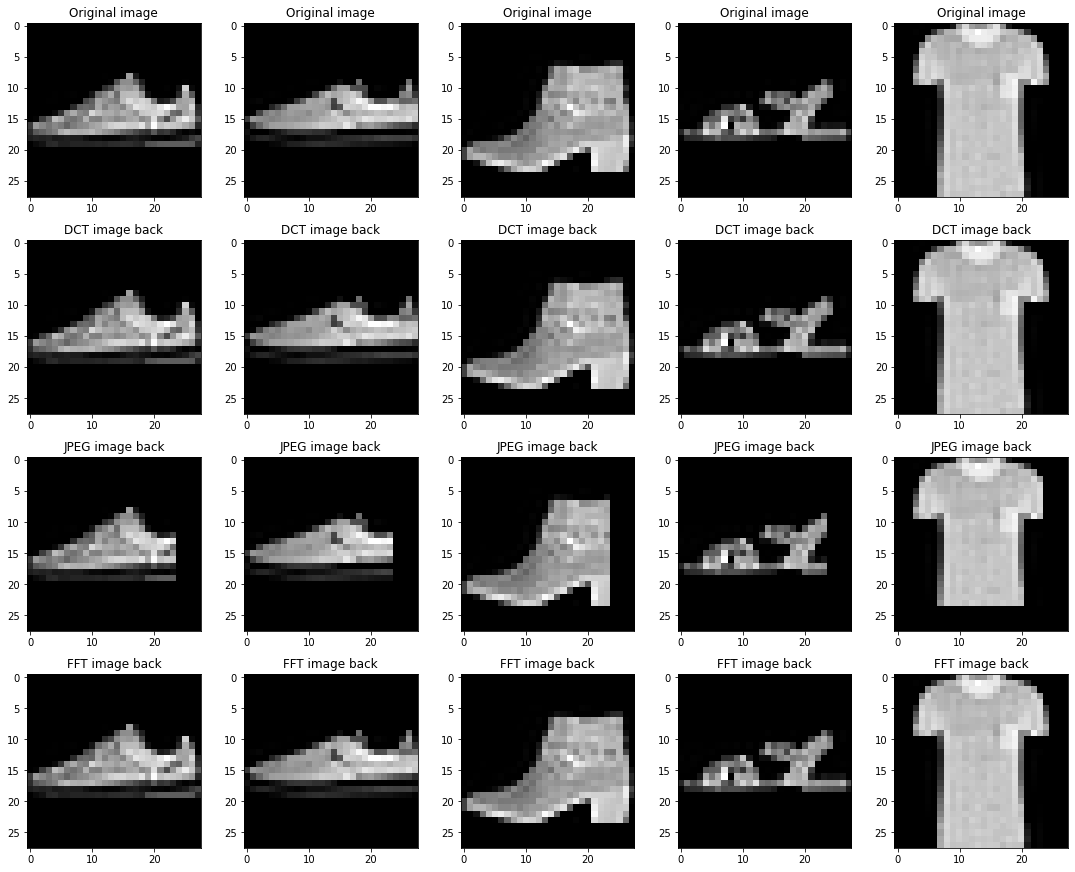

In [22]:
#Pixel vs DCT vs FFT (II)

images_dct_back = rt.block_idct(images_dct)
images_jpeg_back = rt.batch_idct(images_jpeg)
images_fft_back = torch.fft.ifft(images_fft).real

fig, axs = plt.subplots(4, num_images, constrained_layout=True, figsize=(15, 12))

for i in range(num_images):
    axs[0,i].imshow(images[i,0], cmap='gray', interpolation='none')
    axs[0,i].set_title(f'Original image')

for i in range(num_images):
    axs[1,i].imshow(images_dct_back[i,0], cmap='gray', interpolation='none')
    axs[1,i].set_title(f'DCT image back')

for i in range(num_images):
    axs[2,i].imshow(images_jpeg_back[i,0], cmap='gray', interpolation='none')
    axs[2,i].set_title(f'JPEG image back')

for i in range(num_images):
    axs[3,i].imshow(images_fft_back[i,0], cmap='gray', interpolation='none')
    axs[3,i].set_title(f'FFT image back')

The error after converting back is always lower than 10**(-12) except for JPEG with block sizes that can not divide evenly the image size. Standard block size is 8 for JPEG and Fashion Mnist image size is 28x28 (28/8=3.5, which is not int).

In [23]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [24]:
#MSE LOSS from dct transformation

example_data_back_dct = rt.block_idct(rt.block_dct(example_data))
mse_loss = nn.MSELoss()
output = mse_loss(example_data, example_data_back_dct)
print('MSE loss after DCT transformation:', output.item())

MSE loss after DCT transformation: 3.509062344083519e-13


In [25]:
#MSE LOSS from jpeg transformation

example_data_back_jpeg = rt.batch_idct(rt.batch_dct(example_data))
mse_loss = nn.MSELoss()
output = mse_loss(example_data, example_data_back_jpeg)
print('MSE loss after JPEG transformation:', output.item())

MSE loss after JPEG transformation: 0.028561387211084366


In [26]:
#MSE LOSS from fft transformation

example_data_back_fft = torch.fft.ifft(torch.fft.fft(example_data)).real
mse_loss = nn.MSELoss()
output = mse_loss(example_data, example_data_back_fft)
print('MSE loss after FFT transformation: ', output.item())

MSE loss after FFT transformation:  1.8370630554552557e-15


JPEG error in the corrected transformed part, i.e, in the parts that are considerer in the 8x8 blocks (24x24 pixels out of 28x28) is also lower than 10**(-12). It is actually even lower than standard dct in that same region.

In [27]:
#MSE LOSS from dct transformation cropped

example_data_back_dct_crop = rt.block_idct(rt.block_dct(example_data[:,:,:24,:24]))
mse_loss = nn.MSELoss()
output = mse_loss(example_data[:,:,:24,:24], example_data_back_dct_crop)
print('MSE loss after DCT transformation (cropped 24x24):', output.item())

MSE loss after DCT transformation (cropped 24x24): 2.4191992810049245e-13


In [28]:
#MSE LOSS from jpeg transformation cropped

example_data_back_jpeg_crop = rt.batch_idct(rt.batch_dct(example_data[:,:,:24,:24]))
mse_loss = nn.MSELoss()
output = mse_loss(example_data[:,:,:24,:24], example_data_back_jpeg_crop)
print('MSE loss after JPEG transformation (cropped 24x24):', output.item())

MSE loss after JPEG transformation (cropped 24x24): 4.7019747578987137e-14


Auto-Encoder

In [38]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 9)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(9, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 28 * 28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded



In [39]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)



In [67]:
epochs = 3
outputs = []
losses = []
for epoch in range(epochs):
  for (image, _) in train_loader:
    
  
    # Reshaping the image to (-1, 784)
    image = image.reshape(-1, 28*28)
    
    # Output of Autoencoder
    reconstructed = model(image)
    
    # Calculating the loss function
    loss = loss_function(reconstructed, image)
    
    # The gradients are set to zero,
    # the gradient is computed and stored.
    # .step() performs parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Storing the losses in a list for plotting
    losses.append(loss.detach().numpy())
    outputs.append((epochs, image, reconstructed))




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [63]:
def Average(lst):
    sum_of_list = 0
    for i in range(len(lst)):
        sum_of_list += lst[i]
    average = sum_of_list/len(lst)
    return average
  
losses_avg = Average(losses)

losses_avg

0.08260399621581048

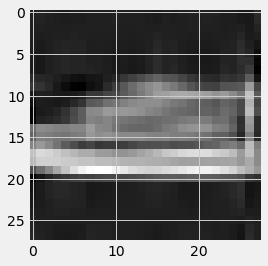

In [64]:
for i, item in enumerate(image): 
  # Reshape the array for plotting
  item = item.reshape(-1, 28, 28)
  plt.imshow(item[0],cmap="gray")
 

In [80]:
def adv_back_to_pixel_autoencoder(back_images):
  epochs = 5
  outputs = []
  losses = []
  for (image) in back_images:
    

    # Reshaping the image to (-1, 784)
    image = image.reshape(-1, 28*28)
    
    # Output of Autoencoder
    reconstructed = model(image)
    
    # Calculating the loss function
    loss = loss_function(reconstructed, image)
    
    # The gradients are set to zero,
    # the gradient is computed and stored.
    # .step() performs parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Storing the losses in a list for plotting
    losses.append(loss.detach().numpy())
    outputs.append((epochs, image, reconstructed))
    return losses , outputs


In [81]:
# images_dct back
losses_dct_back,outputs_dct_back = adv_back_to_pixel_autoencoder(images_dct_back)
dct_back_ae_loss = Average(losses_dct_back)
dct_back_ae_loss

0.0185379721224308

In [83]:
#images jpeg back
losses_jpeg_back,outputs_dct_back = adv_back_to_pixel_autoencoder(images_jpeg_back)
jpeg_back_ae_loss = Average(losses_jpeg_back)
jpeg_back_ae_loss
#images_fft_back = torch.fft.ifft(images_fft).real

0.019356071949005127

In [84]:
#images fft back
losses_fft_back,outputs_dct_back = adv_back_to_pixel_autoencoder(images_fft_back)
fft_back_ae_loss = Average(losses_fft_back)
fft_back_ae_loss

0.012906324118375778

# Attack/pertubation comparison

The attack comparison will be done using random perturbations (STOCHASTIC_ATTACK) and a simple attack FGSM.

JPEG splits image in blocks of size 8. FashionMnist images size is 28x28, therefore some black borders can be seen in the bottom and right pixels.

FFT seems to be weaker independently of the perturbation range (eps). FFT for eps=1 shows attacks with similar strength as the other representations with eps=0.3.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

AttributeError: ignored

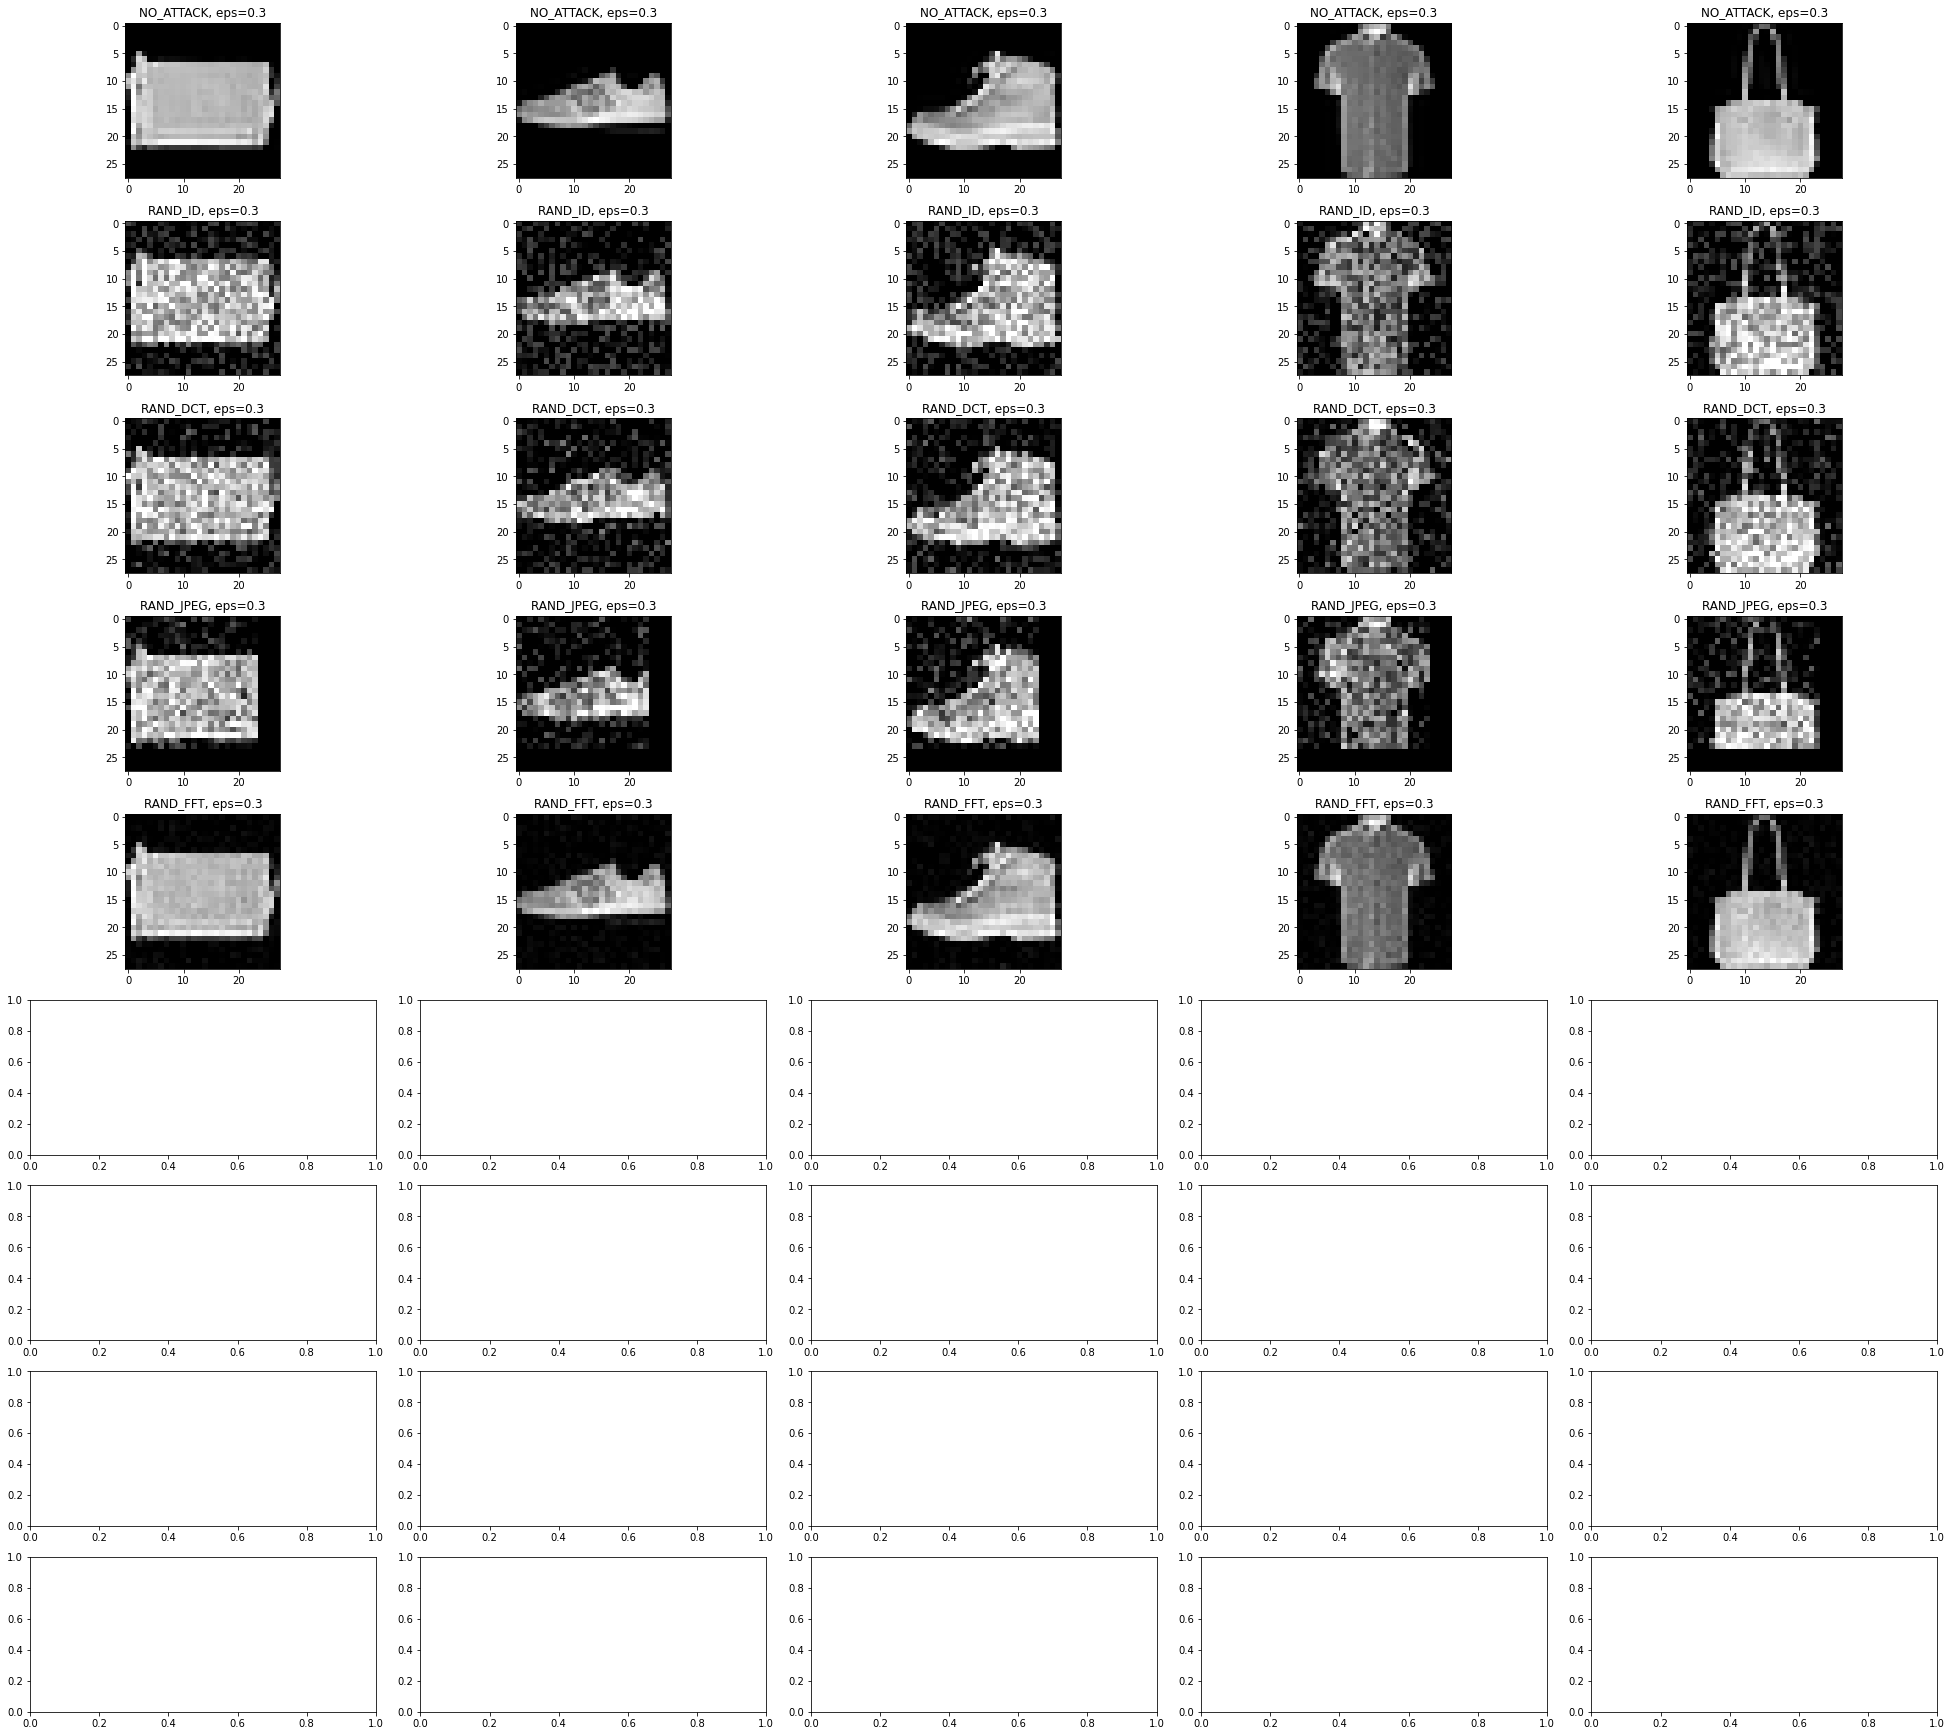

In [28]:
#Pixel representation

num_images = 5
eps = 0.3

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
model_used, _ = generate_model()
atks_list = generate_atks(model_used, eps=eps)

num_attacks = len(atks_list)
fig, axs = plt.subplots(num_attacks, num_images, constrained_layout=True, figsize=(3*num_attacks, 24))

for i in range(num_attacks):
    for j in range(num_images):
        image = example_data[j:j+1,:1,:,:]
        label = example_targets[j:j+1]
        atk = atks_list[i]
        images_atk = atk(image, label).cuda()[0,0]
        axs[i,j].imshow(images_atk.cpu().numpy(), cmap='gray', interpolation='none')
        axs[i,j].set_title(f'{atk.attack}, eps={eps}')

In [ ]:
#Pixel representation

num_images = 5
eps = 1

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
model_used, _ = generate_model()
atks_list = generate_atks(model_used, eps=eps)

num_attacks = len(atks_list)
fig, axs = plt.subplots(num_attacks, num_images, constrained_layout=True, figsize=(3*num_attacks, 24))

for i in range(num_attacks):
    for j in range(num_images):
        image = example_data[j:j+1,:1,:,:]
        label = example_targets[j:j+1]
        atk = atks_list[i]
        images_atk = atk(image, label).cuda()[0,0]
        axs[i,j].imshow(images_atk.cpu().numpy(), cmap='gray', interpolation='none')
        axs[i,j].set_title(f'{atk.attack}, eps={eps}')

# Other comparisons

## JPEG block size comparison

Block size doesn't seem to alter the trnasformation error. Except when the total size is not a multiple of the block_size (example: block_size 8 for image_size 28x28).

In [ ]:
#JPEG comparison

num_images = 5
steps = 5
img_size = 3

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
images = example_data[0:num_images]

block_sizes = [1,2,4,7,8,14,28]
n_sizes = len(block_sizes)

fig, axs = plt.subplots(1+n_sizes, num_images, constrained_layout=True, figsize=(15, 20))

for i in range(num_images):
    axs[0,i].imshow(images[i,0], cmap='gray', interpolation='none')
    axs[0,i].set_title(f'Original image')

for j, b_size in enumerate(block_sizes):
    images_jpeg = rt.batch_dct(images, block_size=b_size)
    for i in range(num_images):
        axs[j+1,i].imshow(images_jpeg[i,0], cmap='gray', interpolation='none')
        axs[j+1,i].set_title(f'JPEG, Block_size: {b_size}')

In [ ]:
#JPEG comparison

num_images = 5
block_sizes = [1,2,4,7,8,14,28]
n_sizes = len(block_sizes)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
images = example_data[0:num_images]


fig, axs = plt.subplots(1+n_sizes, num_images, constrained_layout=True, figsize=(15, 20))

for i in range(num_images):
    axs[0,i].imshow(images[i,0], cmap='gray', interpolation='none')
    axs[0,i].set_title(f'Original image')

for j, b_size in enumerate(block_sizes):
    images_jpeg = rt.batch_idct(rt.batch_dct(images, block_size=b_size), block_size=b_size)
    for i in range(num_images):
        axs[j+1,i].imshow(images_jpeg[i,0], cmap='gray', interpolation='none')
        axs[j+1,i].set_title(f'JPEG back, Block_size: {b_size}')

Error increases linearly if divisible block sizes are considered. Otherwise, the undivisble block sizes have much larger error.

In [ ]:
#MSE LOSS from JPEG transformation with different block sizes

num_images = 5
block_sizes = [1,2,4,7,14,28]
block_sizes_non_div = list(range(1,29))

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
mse_loss = nn.MSELoss()
error_list = []
error_list_non_div = []
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 5))

for j, b_size in enumerate(block_sizes):
    example_data_back_jpeg = rt.batch_idct(rt.batch_dct(example_data, block_size=b_size), block_size=b_size)
    output = mse_loss(example_data, example_data_back_jpeg)
    error_list.append(output.item())
    print(f'MSE loss after JPEG transformation with block size {b_size}: {output.item()}')
    
axs[0].scatter(block_sizes, error_list)
axs[0].set_title('Error vs block size')

for j, b_size in enumerate(block_sizes_non_div):
    example_data_back_jpeg = rt.batch_idct(rt.batch_dct(example_data, block_size=b_size), block_size=b_size)
    output = mse_loss(example_data, example_data_back_jpeg)
    error_list_non_div.append(output.item())
    
axs[1].scatter(block_sizes_non_div, error_list_non_div)
axs[1].set_title('Error vs block size (non div)')

## DCT  comparison

DCT transformation stores most of the information in the top left corner (low frequency waves). This is due to images having locally the same color, i.e., given a white pixel the surrounding pixels will most likelly be also white. The same for black.

This can be used to reduce the representation space to just a cetain amount of low frequency waves. Here some examples will be shown for different sizes considered of the top left corner of the dct representation.

In [ ]:
#DCT subspace comparison

num_images = 5
threshold_sizes = [28,20,15,10,5,3,2,1,0]
n_sizes = len(threshold_sizes)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
images = example_data[0:num_images]
images_dct = rt.block_dct(images)

fig, axs = plt.subplots(1+n_sizes, num_images, constrained_layout=True, figsize=(15, 20))

for i in range(num_images):
    axs[0,i].imshow(images[i,0], cmap='gray', interpolation='none')
    axs[0,i].set_title(f'Original image')

for j, thresh in enumerate(threshold_sizes):
    images_dct_alt = images_dct.clone()
    images_dct_alt[:,:,thresh:,thresh:]=0
    images_dct_alt_back = rt.block_idct(images_dct_alt)
    for i in range(num_images):
        axs[j+1,i].imshow(images_dct_alt_back[i,0], cmap='gray', interpolation='none')
        axs[j+1,i].set_title(f'DCT, threshold: {thresh}')

The less amount of waves considered the more error it is added in the transformation.

Maybe this can be used as data augmentation or an attack generation????????????????

In [ ]:
#DCT subspace comparison

num_images = 5
threshold_sizes = [28,20,15,10,5,3,2,1,0]
n_sizes = len(threshold_sizes)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
images_dct = rt.block_dct(example_data)
error_list = []

for j, thresh in enumerate(threshold_sizes):
    images_dct_alt = images_dct.clone()
    images_dct_alt[:,:,thresh:,thresh:]=0
    images_dct_alt_back = rt.block_idct(images_dct_alt)
    output = mse_loss(example_data, images_dct_alt_back)
    error_list.append(output.item())
    print(f'MSE loss after DCT transformation with threshold {thresh}: {output.item()}')
    
plt.plot(threshold_sizes, error_list)
plt.title('Error per waves considered')